In [1]:
from moist_konrad import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
#### PRECIPITATION TEST
heat_sink = 0.
E_imbalance = 0.
opacity = 66.
albedo = 0.2

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=295,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

print(surface.albedo)
surface.albedo = albedo
print(surface.albedo)

radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
T_atm_low = surface['temperature'].copy()

ndays = 15000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

printcounter = 0
status = 0

tol = 1e-5

dE_1 = [1e8]
OLR_1 = [1e8]
NSW_1 = [1e8]
T_sfc_1 = [1e8]
toa_1 = [1e8]
T_low_1 = [1e8]

#### RCE FOR PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6
for i in range(nsteps):
    
    #surface fluxes
    z = height(atmosphere['plev'],atmosphere['T'][0].copy(),
               atmosphere['phlev'][0],surface['temperature'].copy())
    zini = 10
    
    T_ini,vmr_ini = T_vmr_z(T_atm_low,atmosphere['T'][0][0].copy(),
                            atmosphere['H2O'][0,0].copy(),atmosphere['H2O'][0,1].copy(),
                            z,zini)
    
    LH = 140
    SH = 15
    
    #convective adjustment of the armosphere
    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
    T_atm_low,E_imbalance,prec_mass,RH,cold_point,conv_top = RCPE_step(timestep,
                                                                          atmosphere,surface,radiation,clearsky,
                                                                          SH,LH,albedo,
                                                                          conv_top,
                                                                           strong_coupling = True,
                                                                           constrain_RH = True)
    
        
    print(E_imbalance,T_atm_low,surface['temperature'])
    #update surface temperature with energetic fluxes (latent and radiative)
    
    
    status += 1
    if printcounter == 200:
        print(status/2)
        printcounter = 0
        print(surface['temperature'],SH,LH,prec_mass*Lv/seconds_day/timestep,
              E_imbalance,np.maximum(0.,np.minimum(1.,LH/(LH+SH))))
        print(RH[0])
        print(T_atm_low)
    printcounter += 1

    
    dE_1.append(E_imbalance.copy())
    OLR_1.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())
    NSW_1.append(radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy())
    T_sfc_1.append(surface['temperature'].copy())
    toa_1.append(radiation['toa'].copy())
    T_low_1.append(T_ini.copy())
    
    if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
        print(i)
        break
    
    
### Record RCE 1xCO2
RH_1 = RH.copy()
Mw_1 = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']).copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
SH_1 = SH
LH_1 = LH
Prec_1 = prec_mass.copy()/timestep
atm_rad_1 = atm_rad.copy()
sfc_rad_1 = net_rad_surface.copy()

0.5
0.2
1923.518241420631 [295.] [295.]
-4.512416857856291 [295.] [295.]
-4.79428953959986 [295.] [295.]
-4.794376761802921 [295.] [295.]
-4.7947609916660525 [295.] [295.]
-4.792397410560537 [295.] [295.]
-4.790441554751661 [295.] [295.]
-4.788787664671739 [295.] [295.]
-4.784417751210707 [295.] [295.]
-4.779847220469404 [295.] [295.]
-4.774974156993407 [295.] [295.]
-4.769283773060198 [295.] [295.]
-4.762823001974159 [295.] [295.]
-4.7558876812899555 [295.] [295.]
-4.747924775845474 [295.] [295.]
-4.7387422612309456 [295.] [295.]
-4.731194287682021 [295.] [295.]
-4.719283680750264 [295.] [295.]
-4.710984560284349 [295.] [295.]
-4.700120305231324 [295.] [295.]
-4.689446216755443 [295.] [295.]
-4.679063675006231 [295.] [295.]
-4.6653264953472 [295.] [295.]
-4.6530367141630915 [295.] [295.]
-4.642112439484508 [295.] [295.]
-4.627135562035773 [295.] [295.]
-4.614804691837894 [295.] [295.]
-4.601083396198573 [295.] [295.]
-4.587248609717245 [295.] [295.]
-4.574486985692271 [295.] [295.]
-4

In [3]:
print('P',Prec_1)
print('LH',LH_1)
print('SH',SH_1)
print('R_sfc',sfc_rad_1)
print('R_sfc-LH-SH',sfc_rad_1-SH_1-LH_1)
print('R_atm', atm_rad_1)
print('R_atm+SH+LP', atm_rad_1 + SH + Lv*Prec_1/seconds_day)
print('toa indirect',sfc_rad_1+atm_rad_1)
print('toa direct',toa_1[-1])
print('Energy imbalance',dE_1[-1])
print('Energy imbalance in mm/day', dE_1[-1]/Lv *seconds_day)
print('E',LH_1/Lv * seconds_day)
print('RH_surface',RH_1[0])
print('T_sfc',T_sfc_1[-1])
print('WVP',Mw_1)

P 4.641786751104505
LH 140
SH 15
R_sfc 162.33637137618393
R_sfc-LH-SH 7.3363713761839335
R_atm -149.10269878597063
R_atm+SH+LP 0.2619848310706345
toa indirect 13.233672590213303
toa direct [13.23367259]
Energy imbalance -3.5405398197637665
Energy imbalance in mm/day -0.12231213131850836
E 4.836465413834466
RH_surface 0.95
T_sfc [295.]
WVP 44.7329571890489


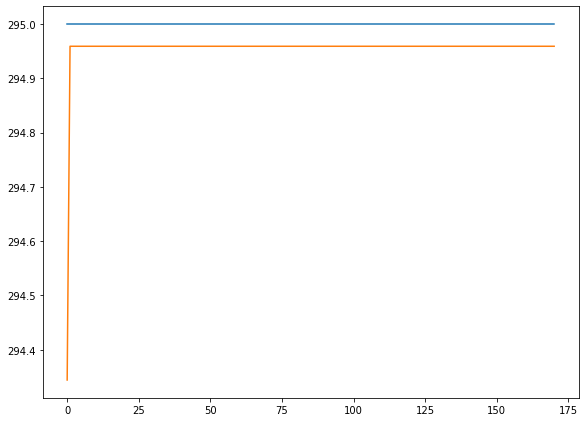

In [4]:
fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))
T_sfc_rec = np.array(T_sfc_1[1:])
T_low_rec = np.array(T_low_1[1:])
plt.plot(T_sfc_rec)
plt.plot(T_low_rec)
plt.show()

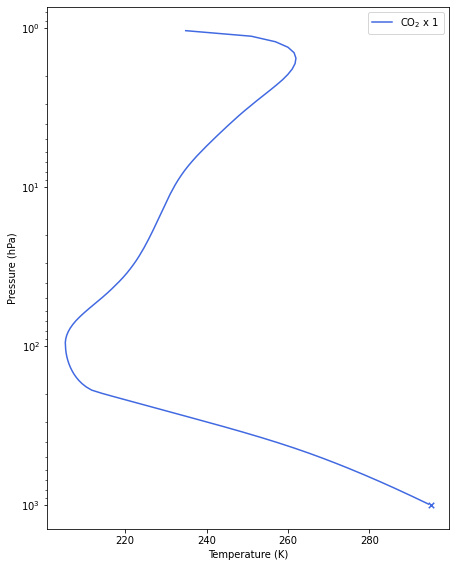

In [5]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(T_atm_1, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()